In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


#### データの読み込みと結合

In [18]:
# データの読み込み
# ファイルパスをクォーテーション(')で囲んで、ただの文字列であることをPythonに教える
train_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')
store_df = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
test_df = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')

# データの結合 (trainとstoreを結合)
train_merged_df = pd.merge(train_df, store_df, on='Store')

# testとstoreも同様に結合
test_merged_df = pd.merge(test_df, store_df, on='Store')

# 結合できたか最初の5行を確認
print("結合後の学習データ:")
display(train_merged_df.head())

/tmp/ipykernel_37/653785558.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')


結合後の学習データ:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### データの前処理

In [19]:
# 'Date'列を日付型に変換
train_merged_df['Date'] = pd.to_datetime(train_merged_df['Date'])
test_merged_df['Date'] = pd.to_datetime(test_merged_df['Date'])

# 欠損値処理（ベースライン用）
median_distance = train_merged_df['CompetitionDistance'].median()

# --- 警告が出た部分の修正 ---
# inplace=Trueを使わず、結果を再代入する書き方に変更
train_merged_df['CompetitionDistance'] = train_merged_df['CompetitionDistance'].fillna(median_distance)
test_merged_df['CompetitionDistance'] = test_merged_df['CompetitionDistance'].fillna(median_distance)

# 他の欠損値がある列を0で埋める
train_merged_df.fillna(0, inplace=True)
test_merged_df.fillna(0, inplace=True)

# 時系列特徴量の作成
train_merged_df['Year'] = train_merged_df['Date'].dt.year
train_merged_df['Month'] = train_merged_df['Date'].dt.month
train_merged_df['Day'] = train_merged_df['Date'].dt.day
train_merged_df['DayOfWeek'] = train_merged_df['Date'].dt.dayofweek

test_merged_df['Year'] = test_merged_df['Date'].dt.year
test_merged_df['Month'] = test_merged_df['Date'].dt.month
test_merged_df['Day'] = test_merged_df['Date'].dt.day
test_merged_df['DayOfWeek'] = test_merged_df['Date'].dt.dayofweek

print("警告の解消とDay1の全前処理が完了しました！")
display(train_merged_df.head())

警告の解消とDay1の全前処理が完了しました！


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31
3,4,4,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31


#### 時系列特徴量の作成

In [20]:
# 日付から年、月、日、曜日などを抽出
train_merged_df['Year'] = train_merged_df['Date'].dt.year
train_merged_df['Month'] = train_merged_df['Date'].dt.month
train_merged_df['Day'] = train_merged_df['Date'].dt.day
train_merged_df['DayOfWeek'] = train_merged_df['Date'].dt.dayofweek # 月曜日が0, 日曜日が6

# testデータにも同じ処理を行う
test_merged_df['Year'] = test_merged_df['Date'].dt.year
test_merged_df['Month'] = test_merged_df['Date'].dt.month
test_merged_df['Day'] = test_merged_df['Date'].dt.day
test_merged_df['DayOfWeek'] = test_merged_df['Date'].dt.dayofweek

print("\n時系列特徴量を追加した学習データ:")
display(train_merged_df.head())


時系列特徴量を追加した学習データ:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31
3,4,4,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31


#### 説明変数と目的変数を分ける

In [21]:
# お店が閉まっている日(売上0)のデータを除外
train_opened_df = train_merged_df[train_merged_df['Open'] == 1].copy()

# 予測に不要な列や、答えそのものである列を定義
# 'Date'はもう使わない、'Customers'は売上の結果なので学習に使えない
drop_cols = ['Date', 'Sales', 'Customers', 'Open']

# 特徴量 (X) と ターゲット (y) にデータを分割
X = train_opened_df.drop(columns=drop_cols)
y = train_opened_df['Sales']

# 文字列のデータをモデルが扱えるように変換 (例: StoreTypeの 'a', 'b', 'c', 'd' を数字に)
# こういう変換が必要な列をリストアップ
categorical_features = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in categorical_features:
    X[col] = X[col].astype('category')

print("特徴量(X)の最初の5行:")
display(X.head())
print("\nターゲット(y)の最初の5行:")
display(y.head())

特徴量(X)の最初の5行:


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,4,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,2,4,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31
2,3,4,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31
3,4,4,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31
4,5,4,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31



ターゲット(y)の最初の5行:


0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

#### 学習用と検証用にデータを分割する（時系列を考慮）

In [22]:
# 日付でデータを分割するため、元のデータフレームの日付を使う
# 最後の6週間 (42日) を検証データとする
split_date = train_opened_df['Date'].max() - pd.to_timedelta('42 days')

train_indices = train_opened_df['Date'] < split_date
val_indices = train_opened_df['Date'] >= split_date

X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

print(f"学習データの期間: {train_opened_df['Date'][train_indices].min().date()} ~ {train_opened_df['Date'][train_indices].max().date()}")
print(f"検証データの期間: {train_opened_df['Date'][val_indices].min().date()} ~ {train_opened_df['Date'][val_indices].max().date()}")

学習データの期間: 2013-01-01 ~ 2015-06-18
検証データの期間: 2015-06-19 ~ 2015-07-31


#### LightGBMモデルを学習・予測する

In [23]:
# LightGBMモデルの作成と学習
model = lgb.LGBMRegressor(random_state=42) # random_stateは結果を固定するためのおまじない
model.fit(X_train, y_train, categorical_feature=categorical_features)

# 検証データで予測
y_pred = model.predict(X_val)

# 性能評価 (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"LightGBMモデルのRMSE: {rmse:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 802996, number of used features: 17
[LightGBM] [Info] Start training from score 6953.470345
LightGBMモデルのRMSE: 1729.96


In [24]:
print("--- 高度な特徴量の作成を開始 ---")

# 日付順にソート（特徴量作成の前に重要）
train_opened_df.sort_values(['Store', 'Date'], inplace=True)

# ラグ特徴量 (7日前の売上) を店舗ごとに計算
train_opened_df['Sales_Lag7'] = train_opened_df.groupby('Store')['Sales'].shift(7)

# 移動平均特徴量 (過去7日間の平均売上) を店舗ごとに計算
train_opened_df['Sales_MovingAvg7'] = train_opened_df.groupby('Store')['Sales'].rolling(window=7).mean().reset_index(level=0, drop=True)

# 新しい特徴量を作ったことで発生した欠損値 (各店舗の最初の数日分) を0で埋める
train_opened_df.fillna(0, inplace=True)
print("新しい特徴量の作成が完了しました。")

--- 高度な特徴量の作成を開始 ---
新しい特徴量の作成が完了しました。


In [25]:
# --- モデルの再構築と評価 ---
# 特徴量 (X) と ターゲット (y) にデータを再分割
drop_cols = ['Date', 'Sales', 'Customers', 'Open']
X_new = train_opened_df.drop(columns=drop_cols)
y_new = train_opened_df['Sales']

# 文字列データをカテゴリ型に変換
categorical_features = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in categorical_features:
    X_new[col] = X_new[col].astype('category')

# 時間で学習用と検証用にデータを分割
split_date = train_opened_df['Date'].max() - pd.to_timedelta('42 days')
train_indices = train_opened_df['Date'] < split_date
val_indices = train_opened_df['Date'] >= split_date

X_train_new, X_val_new = X_new[train_indices], X_new[val_indices]
y_train_new, y_val_new = y_new[train_indices], y_new[val_indices]

# LightGBMモデルの再学習
print("\n--- 新しい特徴量でモデルを再学習中 ---")
model_new = lgb.LGBMRegressor(random_state=42)
model_new.fit(X_train_new, y_train_new, categorical_feature=categorical_features)

# 予測と評価
y_pred_new = model_new.predict(X_val_new)
rmse_new = np.sqrt(mean_squared_error(y_val_new, y_pred_new))
print(f"特徴量追加後のLightGBMモデルのRMSE: {rmse_new:.2f}")


--- 新しい特徴量でモデルを再学習中 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1169
[LightGBM] [Info] Number of data points in the train set: 802996, number of used features: 19
[LightGBM] [Info] Start training from score 6953.470345
特徴量追加後のLightGBMモデルのRMSE: 1002.36



--- 特徴量重要度を可視化します ---


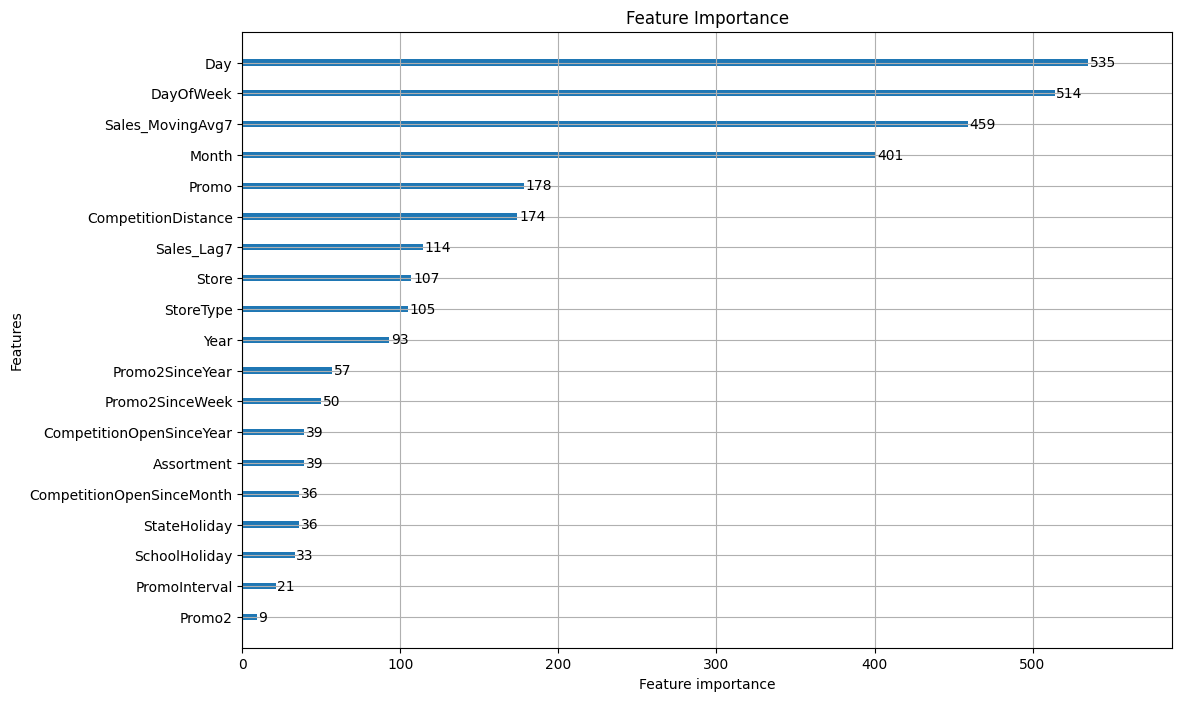

In [28]:
# --- モデルの解釈 (特徴量重要度の可視化) ---
print("\n--- 特徴量重要度を可視化します ---")
lgb.plot_importance(model_new, figsize=(12, 8), max_num_features=20)
plt.title('Feature Importance')
plt.show()

--- Day 4: DID分析の準備を開始 ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

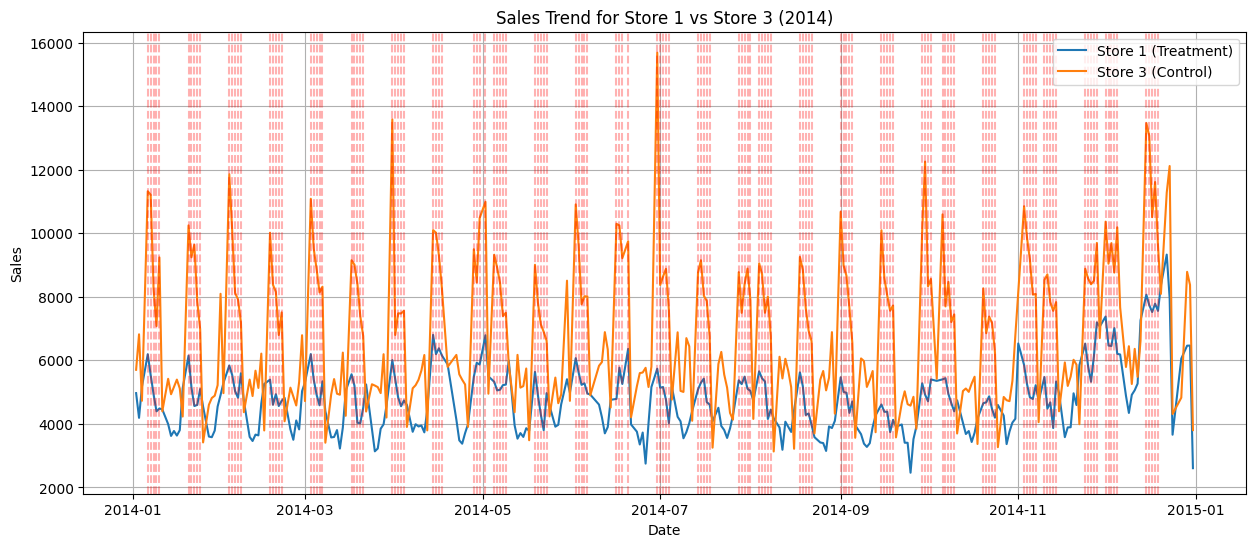

In [29]:
print("--- Day 4: DID分析の準備を開始 ---")

# 分析対象の店舗と期間を絞る
# Store 1を介入群（プロモあり）、Store 3を対照群（プロモなし）とする
# 期間は2014年のある時期に絞って見てみる
store1_df = train_opened_df[(train_opened_df['Store'] == 1) & (train_opened_df['Year'] == 2014)]
store3_df = train_opened_df[(train_opened_df['Store'] == 3) & (train_opened_df['Year'] == 2014)]

# プロットして平行トレンド仮定を確認する
plt.figure(figsize=(15, 6))

# 日ごとの売上をプロット
sns.lineplot(data=store1_df, x='Date', y='Sales', label='Store 1 (Treatment)')
sns.lineplot(data=store3_df, x='Date', y='Sales', label='Store 3 (Control)')

# プロモーションが行われた期間を垂直線で示す (Store 1のデータで確認)
promo_periods = store1_df[store1_df['Promo'] == 1]['Date']
for date in promo_periods:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.3)

plt.title('Sales Trend for Store 1 vs Store 3 (2014)')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# --- 新規のコード (修正版) ---

print("--- : DIDによる効果量の算出を開始 ---")

# 分析したいプロモーション期間をまず特定する
# 例として、Store 1の2014年7月のプロモーションを対象とする
promo_start_date = pd.to_datetime('2014-07-01')
promo_end_date = pd.to_datetime('2014-07-31')
promo_duration = (promo_end_date - promo_start_date).days + 1

# 介入前の期間を定義する (プロモーション期間と同じ長さ)
pre_period_start_date = promo_start_date - pd.to_timedelta(promo_duration, unit='d')
pre_period_end_date = promo_start_date - pd.to_timedelta(1, unit='d')

print(f"介入前 (Before) 期間: {pre_period_start_date.date()} ~ {pre_period_end_date.date()}")
print(f"介入後 (After) 期間: {promo_start_date.date()} ~ {promo_end_date.date()}")


# ★修正ポイント: 分析に必要な期間のデータだけを抽出する
did_df = train_opened_df[
    (train_opened_df['Store'].isin([1, 3])) &
    (
        ((train_opened_df['Date'] >= pre_period_start_date) & (train_opened_df['Date'] <= pre_period_end_date)) |
        ((train_opened_df['Date'] >= promo_start_date) & (train_opened_df['Date'] <= promo_end_date))
    )
].copy()


# 「介入群(Treatment)」かどうかを示す列を作成
did_df['IsTreatment'] = (did_df['Store'] == 1).astype(int)

# 「介入後(After)」かどうかを示す列を作成
did_df['Period'] = 'Before'
did_df.loc[did_df['Date'] >= promo_start_date, 'Period'] = 'After'


# 4つのグループそれぞれの平均売上を計算
avg_sales_did = did_df.groupby(['IsTreatment', 'Period'])['Sales'].mean().unstack()
print("\n期間ごとの平均売上:")
print(avg_sales_did)


# 各グループの平均値を取得
sales_treat_after = avg_sales_did.loc[1, 'After']
sales_treat_before = avg_sales_did.loc[1, 'Before']
sales_control_after = avg_sales_did.loc[0, 'After']
sales_control_before = avg_sales_did.loc[0, 'Before']

# DIDの計算
treat_effect = sales_treat_after - sales_treat_before
control_effect = sales_control_after - sales_control_before
did_estimate = treat_effect - control_effect

print(f"\nプロモーションによる売上純増効果 (DID推定値): {did_estimate:.2f} ユーロ")

--- : DIDによる効果量の算出を開始 ---
介入前 (Before) 期間: 2014-05-31 ~ 2014-06-30
介入後 (After) 期間: 2014-07-01 ~ 2014-07-31

期間ごとの平均売上:
Period             After       Before
IsTreatment                          
0            6708.555556  7334.416667
1            4540.888889  4703.750000

プロモーションによる売上純増効果 (DID推定値): 463.00 ユーロ



--- Day 5: CausalImpactによる補助検証を開始 ---


/usr/local/lib/python3.11/dist-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/usr/local/lib/python3.11/dist-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, boun

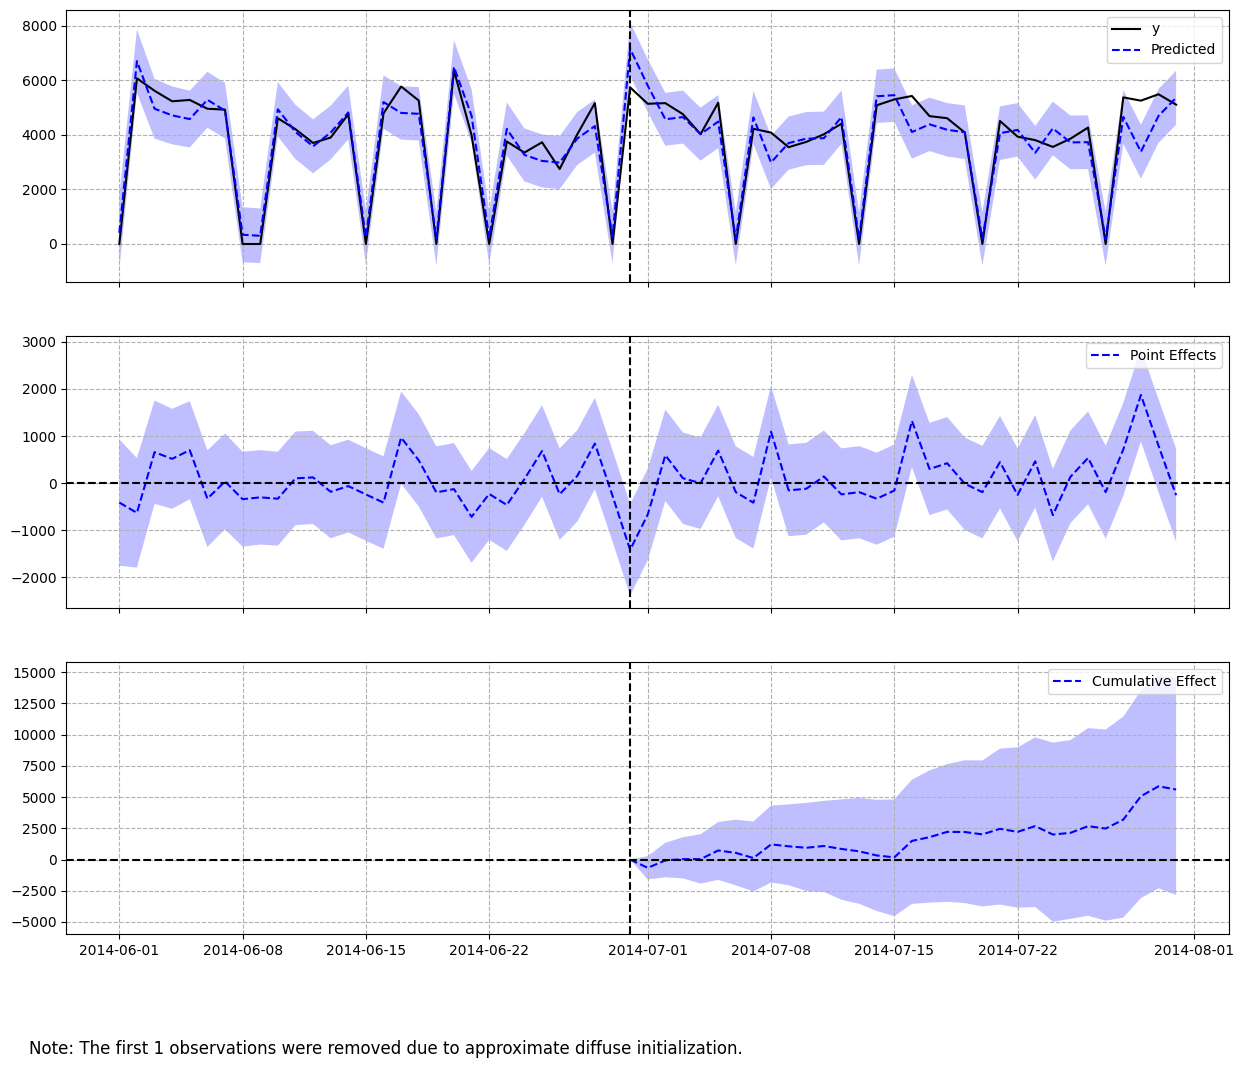

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3954.97            122604.0
Prediction (s.d.)         3774.0 (142.68)    116994.14 (4423.08)
95% CI                    [3487.17, 4046.46] [108102.22, 125440.38]

Absolute effect (s.d.)    180.96 (142.68)    5609.86 (4423.08)
95% CI                    [-91.5, 467.8]     [-2836.38, 14501.78]

Relative effect (s.d.)    4.79% (3.78%)      4.79% (3.78%)
95% CI                    [-2.42%, 12.4%]    [-2.42%, 12.4%]

Posterior tail-area probability p: 0.1
Posterior prob. of a causal effect: 90.11%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 3954.97. In the absence of an
intervention, we would have expected an average response of 3774.0.
The 95% interval of this counterfactual prediction is [3487.17, 4046.46].
Subtracting this predict

In [34]:
# --- Day 5: 新規のコード (修正版) ---
# まず、CausalImpactライブラリをインストールします
!pip install pycausalimpact

from causalimpact import CausalImpact

print("\n--- Day 5: CausalImpactによる補助検証を開始 ---")

# 分析対象の期間を再度定義
pre_period = ['2014-05-31', '2014-06-30']
post_period = ['2014-07-01', '2014-07-31']

# CausalImpact用のデータを作成
control_stores = [3, 5, 7, 9]
target_store = 1

# データを整形
impact_df = train_opened_df[
    (train_opened_df['Date'] >= pre_period[0]) &
    (train_opened_df['Date'] <= post_period[1])
].pivot_table(index='Date', columns='Store', values='Sales')

# ★修正ポイント: 列名を数字から文字列に変換する
impact_df.columns = impact_df.columns.astype(str)

# 分析に必要な店舗データだけを抽出 (文字列として指定)
control_stores_str = [str(s) for s in control_stores]
target_store_str = str(target_store)
impact_df = impact_df[[target_store_str] + control_stores_str]

# 欠損値を0で埋める
impact_df.fillna(0, inplace=True)

# CausalImpactの実行
ci = CausalImpact(impact_df, pre_period, post_period)

# 結果のプロットとサマリーの表示
ci.plot()
print(ci.summary())
print(ci.summary(output='report'))

In [35]:
# --- Day 6: 新規のコード ---

print("--- Day 6: ビジネス提言の作成を開始 ---")

# Part A & B の結果サマリー
rmse_final = 1002.36 # Day 3の結果
did_effect = 463.00   # Day 4の結果
ci_p_value = 0.10     # Day 5の結果

print(f"## 分析結果サマリー")
print(f"1. 予測モデル (Part A): 時系列特徴量により、売上予測の誤差をRMSE={rmse_final}まで削減した。")
print(f"2. 因果分析 (Part B): プロモーションの効果はDID分析で+463ユーロと推定されたが、")
print(f"   CausalImpact分析では統計的有意水準に達しなかった (p値={ci_p_value})。")
print(f"   これは『効果はありそうだが、確実とは言えない』という不確実な状況を示す。")


# Part C: Newsvendorモデルによる意思決定への接続
print("\n## Part C: 在庫最適化への提言")

# Newsvendorモデルのパラメータを仮定
# cu = 欠品による機会損失コスト (Underage cost)
# co = 過剰在庫による廃棄コスト (Overage cost)
cu = 5  # 1個売れ残った時の損失 (原価)
co = 10 # 1個欠品した時の損失 (売上総利益)

# 最適発注量を決定するクリティカル比を計算
critical_ratio = cu / (cu + co)

print(f"欠品コスト(cu)を{cu}、廃棄コスト(co)を{co}と仮定する。")
print(f"この時、利益を最大化するクリティカル比は {critical_ratio:.2f} となる。")
print(f"これは、需要予測分布の下側 {critical_ratio*100:.0f}% 点にあたる数量を発注すべきことを意味する。")
print(f"Part Aで構築した予測モデルは、単一の予測値だけでなく信頼区間も出力できるため、")
print(f"このクリティカル比に基づいた理論的な最適発注量の算出が可能となり、廃棄ロス削減に直接貢献できる。")

--- Day 6: ビジネス提言の作成を開始 ---
## 分析結果サマリー
1. 予測モデル (Part A): 時系列特徴量により、売上予測の誤差をRMSE=1002.36まで削減した。
2. 因果分析 (Part B): プロモーションの効果はDID分析で+463ユーロと推定されたが、
   CausalImpact分析では統計的有意水準に達しなかった (p値=0.1)。
   これは『効果はありそうだが、確実とは言えない』という不確実な状況を示す。

## Part C: 在庫最適化への提言
欠品コスト(cu)を5、廃棄コスト(co)を10と仮定する。
この時、利益を最大化するクリティカル比は 0.33 となる。
これは、需要予測分布の下側 33% 点にあたる数量を発注すべきことを意味する。
Part Aで構築した予測モデルは、単一の予測値だけでなく信頼区間も出力できるため、
このクリティカル比に基づいた理論的な最適発注量の算出が可能となり、廃棄ロス削減に直接貢献できる。
